In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score,recall_score,average_precision_score,mean_absolute_error
from sklearn.metrics import label_ranking_average_precision_score,f1_score,r2_score,accuracy_score,average_precision_score,precision_recall_curve,PrecisionRecallDisplay
import os
import cv2

In [ ]:
# Define constants and paths
input_shape = (256, 256, 3)  # Adjust the image size as needed
batch_size = 32
epochs = 100
num_classes = 4  # Number of apple disease classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/AppleDiseases'  # Update the path to your dataset
save_model_path = 'apple_disease_model.h5'

In [ ]:
# Get the class names (subdirectory names)
class_name = os.listdir(dataset_path)
# Remove the "Apple_" prefix from class names
# class_names = [i.replace("Apple___", "") for i in class_names]

# Display the class names
print("Class Names:")
for cl in class_name:
    print(cl)


Class Names:
Apple___Apple_scab
Apple___Black_rot
Apple___healthy
Apple___Cedar_apple_rust


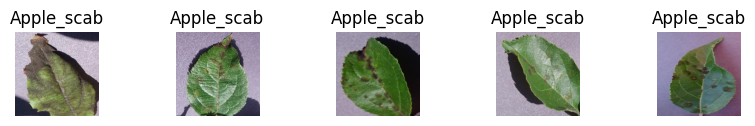

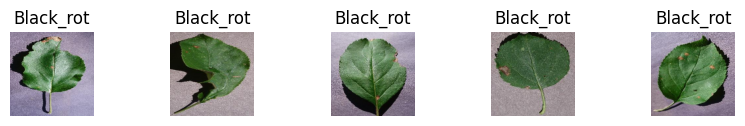

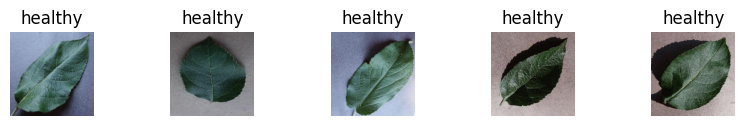

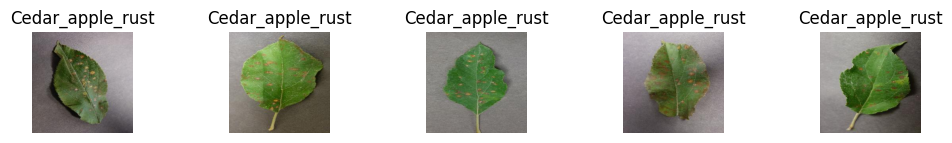

In [ ]:
# Function to visualize raw images
def visualize_raw_images(class_name, num_images=5):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:num_images]

    plt.figure(figsize=(10, num_images))

    for i, img_filename in enumerate(image_files):
        img_path = os.path.join(class_path, img_filename)

        # Load and display the image using load_img
        img = load_img(img_path)
        # Remove the "Apple_" prefix from class names
        class_title = class_name.replace("Apple___", "")

        plt.subplot(4, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_title)
        plt.axis('off')

# Visualize a few raw images from each disease class
num_images_per_class = 5

for cl in class_name:
    visualize_raw_images(cl, num_images=num_images_per_class)

plt.tight_layout()
plt.show()

(256, 256, 3)


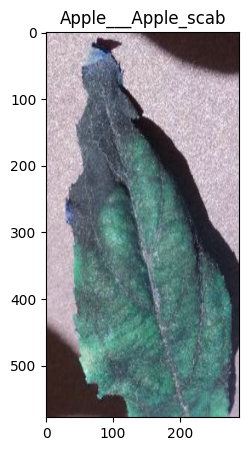

(256, 256, 3)


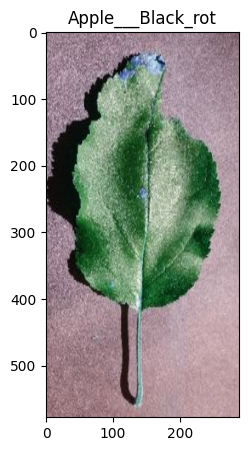

(256, 256, 3)


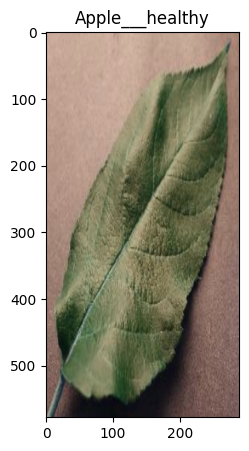

(256, 256, 3)


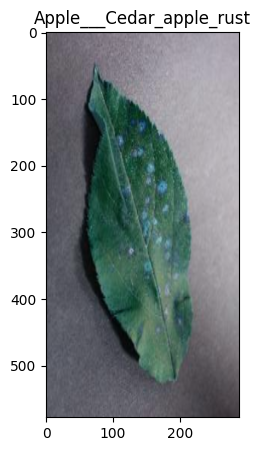

In [ ]:
arr=[]
names=[]
for i in os.listdir(dataset_path):
    for j in os.listdir(dataset_path+'/'+i):
        img=cv2.imread(dataset_path+"/"+i+'/'+j)
        print(img.shape)
        fig=plt.figure(figsize=(10,5))
        img=cv2.resize(img,(290,578))
        arr.append(img)
        plt.imshow(img)
        names.append(i)
        plt.title(i)
        plt.show()
        break

We then changed the colour photo to black and white using picture decolorization. It is referred to as the procedure to convert a colour image to a grayscale image and is frequently used in single-channel image processing, black and white printing, etc. We chose this approach because it makes it simpler to distinguish between diseases like apple scab and apple rot that are brought on by bacterial or fungal infection. The model gains the benefit of being able to train more successfully as a result.

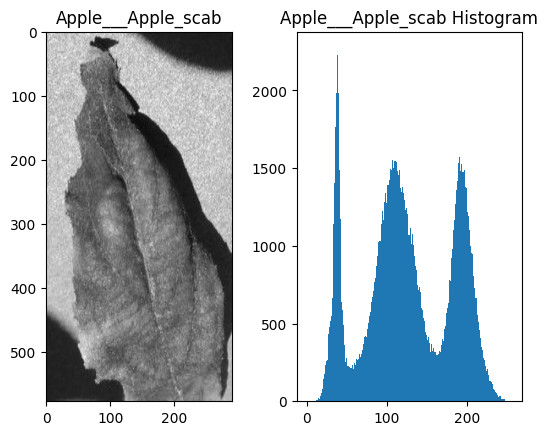

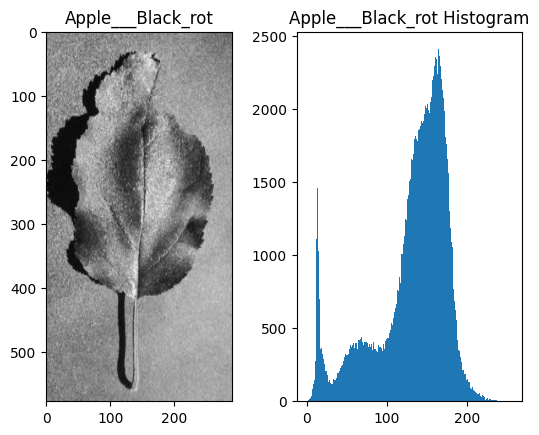

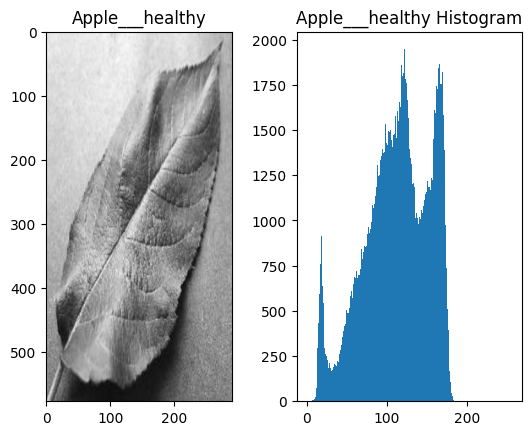

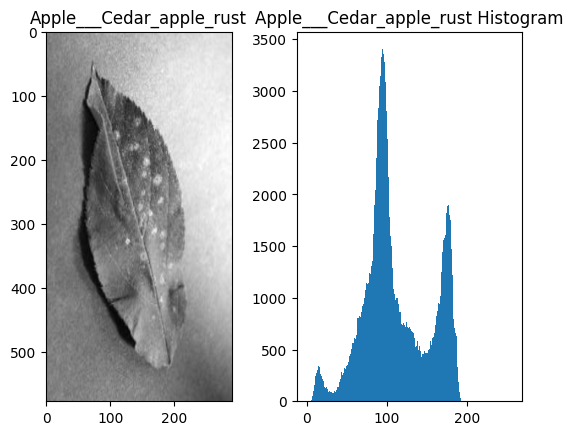

In [ ]:
for i,j in zip(arr,names):
    fig,ax=plt.subplots(1,2)
    i=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    ax[0].imshow(i,'gray')
    ax[1].hist(i.ravel(),256,[0,256])
    ax[0].set_title(j)
    ax[1].set_title(j+" Histogram")
    plt.show()

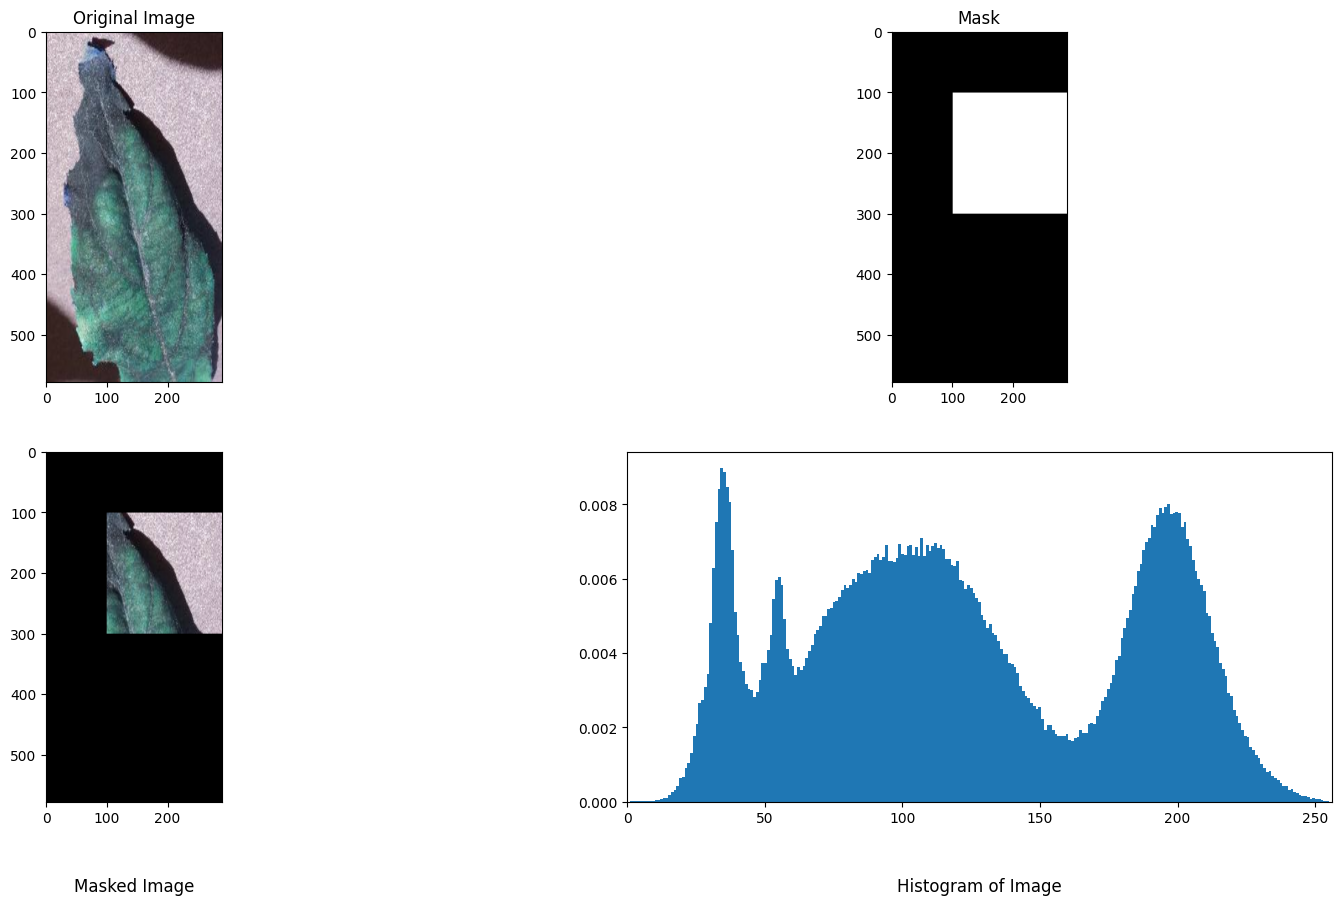

In [ ]:
mask = np.zeros(arr[0].shape[:2], np.uint8)
mask[100:300, 100:400] = 255

masked_img = cv2.bitwise_and(arr[0],arr[0],mask = mask)
# Calculate histogram with mask and without mask
# Check third argument for mask
# hist_full = cv2.calcHist([k],[0],None,256,[1,256])
# hist_mask = cv2.calcHist([k],[0],mask,256,[1,256])

plt.figure(figsize=(20,10))
plt.subplot(221), plt.imshow(arr[0],'gray')
plt.title('Original Image')

plt.subplot(222), plt.imshow(mask,'gray')
plt.title('Mask')

plt.subplot(223), plt.imshow(masked_img,'gray')
plt.title('Masked Image',y=-0.2, pad=-14)

plt.subplot(224), plt.hist(arr[0].ravel(),256,[1,256],'gray')
plt.title('Histogram of Image',y=-0.2, pad=-14)
plt.xlim([0,256])
plt.show()

In [ ]:
# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255, # Rescale pixel values to [0, 1]

    rotation_range=5, # Randomly rotate images by up to 20 degrees

    width_shift_range=0.2, # Randomly shift the width by up to 20%

    height_shift_range=0.2, # Randomly shift the height by up to 20%

    brightness_range=[0.5,1.7],

    shear_range=0.2,  # Shear transformations

    zoom_range=0.2, # Randomly zoom in/out by up to 20%

    horizontal_flip=True, # Randomly flip images horizontally

#     validation_split=0.2 # Split data into training (80%) and validation (20%)
    fill_mode='nearest'
)

In [ ]:
# Split data into training and validation sets
image_files = []
labels = []
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_files.append(os.path.join(folder_path, image_name))
            labels.append(folder_name)

X_train_files, X_val_files, y_train, y_val = train_test_split(
    image_files, labels, test_size=0.4, random_state=42)

train_data = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train_files, 'label': y_train}),
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_data = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val_files, 'label': y_val}),
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1902 validated image filenames belonging to 4 classes.
Found 1269 validated image filenames belonging to 4 classes.


Due to the fact that the data we were able to get was in string format, which made it challenging to train and construct the model, we separated each class of illness into integers such as 0,1,2,3. In order to overcome the obstacle, Label Encoder was used.

In [ ]:
x_train, y_train = next(train_data)
x_test, y_test = next(validation_data)
y_temp=[y_train[1]]
x_temp=np.asarray([x_train[1]])
# x_temp = x_temp.reshape((290, 578, ))
datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True  # horizontal flip
                                   )
i=0
t=[]
for x,y in datagen.flow(x_temp,y_temp,shuffle=False):
    t.append(x[0])
    print(i)
    i+=1
    if(i==4):
        break

0
1
2
3


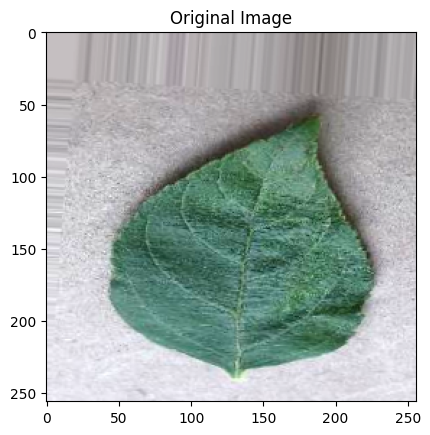

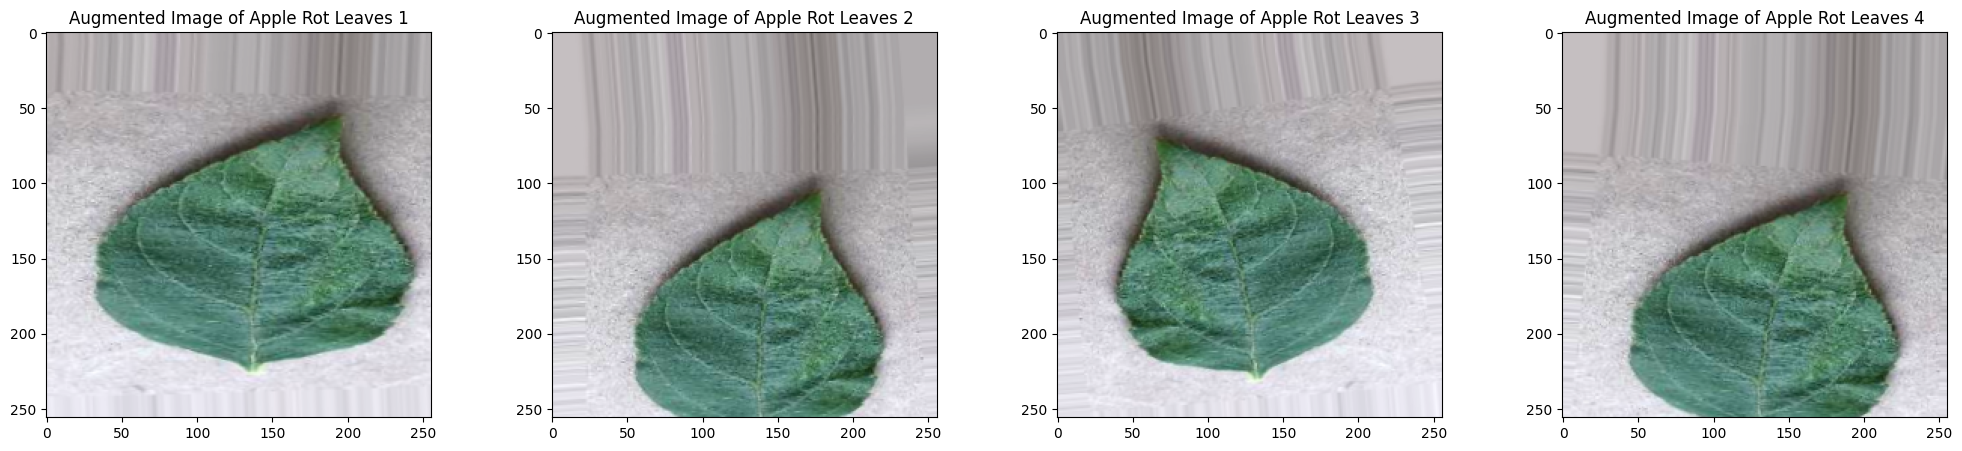

In [ ]:
plt.imshow(x_temp[0])
plt.title('Original Image')
plt.show()

fig,ax=plt.subplots(1,4,figsize=(25,5))
for i in range(len(t)):
    ax[i].set_title('Augmented Image of Apple Rot Leaves '+str(i+1))
    ax[i].imshow(t[i])
plt.show()

In [ ]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(256, 256),
#   layers.experimental.preprocessing.Rescaling(1./255),
# ])
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
#   layers.experimental.preprocessing.RandomContrast(0.2),
#   layers.experimental.preprocessing.RandomZoom(0.2)
# ])


In [ ]:
# Build a CNN model
model = Sequential([
#     resize_and_rescale,
#     data_augmentation,
    #input layer
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),

    #Hidden Layers
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    #Output Layer
    Dense(256, activation='relu'),
    Dropout(0.7),

    Dense(num_classes, activation='softmax')  # Assuming 4 disease classes
])

In [ ]:
# Compile the model
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#early_stopping
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_data,
    callbacks=early_stopping
)

# Save the model
model.save(save_model_path)

Epoch 1/100
60/60 [==============================] - 134s 2s/step - loss: 1.1622 - accuracy: 0.5152 - val_loss: 0.9793 - val_accuracy: 0.5114
Epoch 2/100
60/60 [==============================] - 80s 1s/step - loss: 1.0273 - accuracy: 0.5747 - val_loss: 0.9402 - val_accuracy: 0.5847
Epoch 3/100
60/60 [==============================] - 64s 1s/step - loss: 0.8626 - accuracy: 0.6714 - val_loss: 0.8315 - val_accuracy: 0.6919
Epoch 4/100
60/60 [==============================] - 65s 1s/step - loss: 0.7561 - accuracy: 0.7082 - val_loss: 0.6077 - val_accuracy: 0.7636
Epoch 5/100
60/60 [==============================] - 64s 1s/step - loss: 0.6198 - accuracy: 0.7624 - val_loss: 0.5195 - val_accuracy: 0.8251
Epoch 6/100
60/60 [==============================] - 64s 1s/step - loss: 0.5606 - accuracy: 0.7997 - val_loss: 0.4257 - val_accuracy: 0.8408
Epoch 7/100
60/60 [==============================] - 63s 1s/step - loss: 0.5010 - accuracy: 0.8202 - val_loss: 0.4504 - val_accuracy: 0.8566
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)       

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(save_model_path)

# Data preprocessing for test dataset (no data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the order for evaluation
)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_data, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Found 3171 images belonging to 4 classes.
100/100 [==============================] - 10s 95ms/step - loss: 0.0669 - accuracy: 0.9804
Test Loss: 0.06687835603952408
Test Accuracy: 0.9804478287696838


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

# Assuming y_true is the true labels and y_pred is the predicted labels
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:",f1)

1/1 [==============================] - 0s 148ms/step
Precision: 0.9308035714285714
Recall: 0.90625
F1 Score: 0.9071657509157509


In [ ]:
from sklearn.metrics import precision_score,recall_score,average_precision_score,mean_absolute_error,label_ranking_average_precision_score,f1_score,r2_score,accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, average_precision_score,precision_recall_curve,PrecisionRecallDisplay
class_names = [i.replace("Apple___", "") for i in class_name]
def plot_model(hist,model_name):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(model_name+" accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy", "Validation Accuracy", "loss", "Validation Loss"])
    plt.show()

def plot_confusionmatrix(model,y_test):
    y_pred=model.predict(x_test)
    y_pred=np.argmax(y_pred, axis=1)
    test=np.argmax(y_test, axis=1)
    cm = confusion_matrix(test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot()

result=pd.DataFrame(columns=['Name of Model','accuracy',"F1-Score","R2-Score","Precision",'Recall','MAE'])
result

def addResult(model_name,model,y_test):
    pred=model.predict(x_test)
    pred=np.argmax(pred, axis=1)
    test=np.argmax(y_test, axis=1)
    result.loc[len(result.index)]=[model_name,
                                    accuracy_score(pred,test),
                                    f1_score(pred,test,average='weighted'),
                                    r2_score(pred,test),
                                    precision_score(pred,test,average='weighted'),
                                    recall_score(pred,test,average='weighted'),
                                    mean_absolute_error(test,pred)]


def plot_precisionrecallcurve(model,test):
    y_pred=model.predict(x_test)
    # y_pred=np.argmax(y_pred, axis=1)
    # test=np.argmax(test, axis=1)
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(class_name)):
        precision[i], recall[i], _ = precision_recall_curve(test[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        test.ravel(), y_pred.ravel()
    )
    average_precision["micro"] = average_precision_score(test, y_pred, average="micro")
    display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
                                        )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged over all classes")
    plt.show()


1/1 [==============================] - 0s 35ms/step


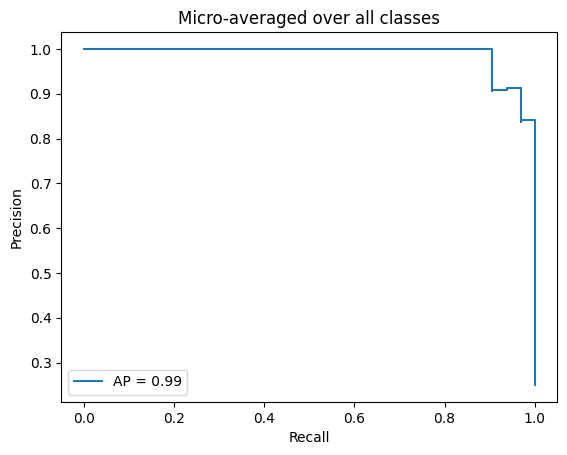

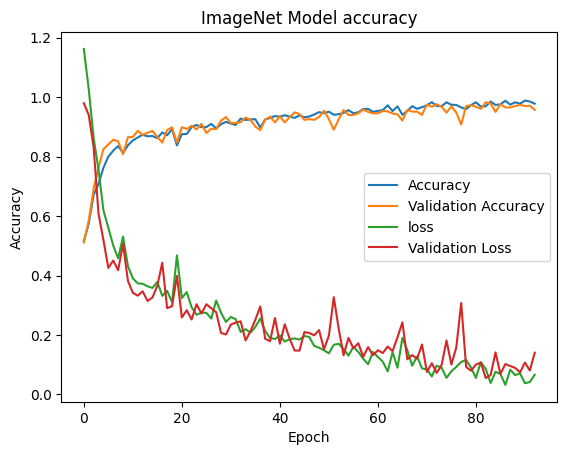

1/1 [==============================] - 0s 42ms/step


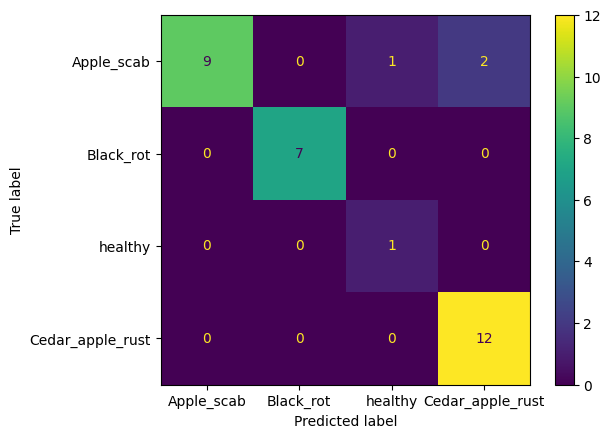

In [ ]:
from sklearn.metrics import precision_score,recall_score,average_precision_score,mean_absolute_error,label_ranking_average_precision_score,f1_score,r2_score,accuracy_score,average_precision_score,precision_recall_curve,PrecisionRecallDisplay

plot_precisionrecallcurve(model,y_test)
plot_model(history,'ImageNet Model')
addResult("9",model,y_test)
plot_confusionmatrix(model,y_test)

In [ ]:
# Define the path to the single image you want to predict
image_path = "/content/drive/MyDrive/AppleDiseases/Apple___Cedar_apple_rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG"

# Load and preprocess the single image
img = load_img(image_path, target_size=(256, 256))  # Adjust the target size as per your model's input size
img_array = img_to_array(img)
img_array = img_array / 255.0  # Rescale pixel values to [0, 1]

# Add a batch dimension (required for model.predict)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions on the single image
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Assuming you have a list of class names
class_names = ["Apple_scab", "Black_rot", "Cedar_apple_rust", "Healthy"]

# Get the predicted class label
predicted_class = class_names[predicted_class_index]

# Print the predicted class label and probabilities
print("Original: ", image_path[36:-58])
print(f'Predicted class: {predicted_class}')
print(f'Class probabilities: {predictions[0]}')

1/1 [==============================] - 0s 383ms/step
Original:  /Apple___Cedar_apple_rust/0
Predicted class: Cedar_apple_rust
Class probabilities: [2.5306497e-06 4.2829188e-07 9.9999702e-01 1.4680159e-08]


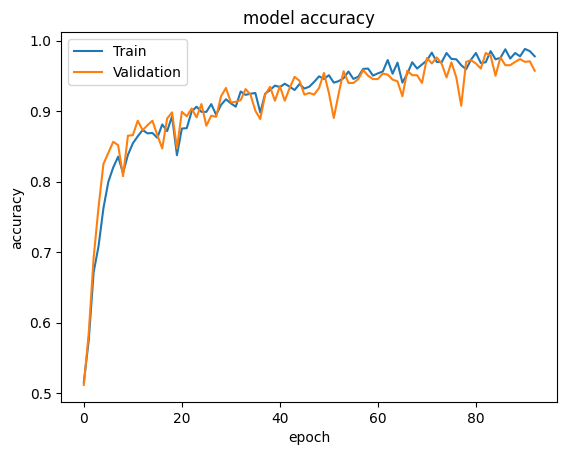

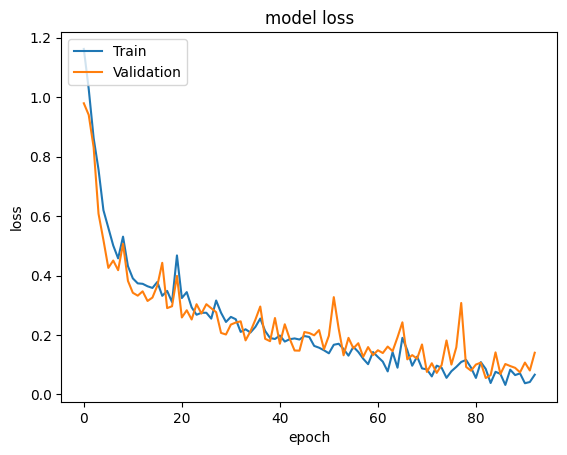

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()